<a href="https://colab.research.google.com/github/KimJunGu9/DeepLearning_Pytorch/blob/main/1_1_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 라이브러리 호출

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

### CPU 또는 GPU 장치 확인

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### fashion_mnist 데이터셋 내려받기

In [4]:
train_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/DL_pytorch/chap05/data', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))

test_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/DL_pytorch/chap05/data', download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()]))

### fashion_mnist 데이터를 데이터로더에 전달

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

### 분류에 사용될 클래스 정의

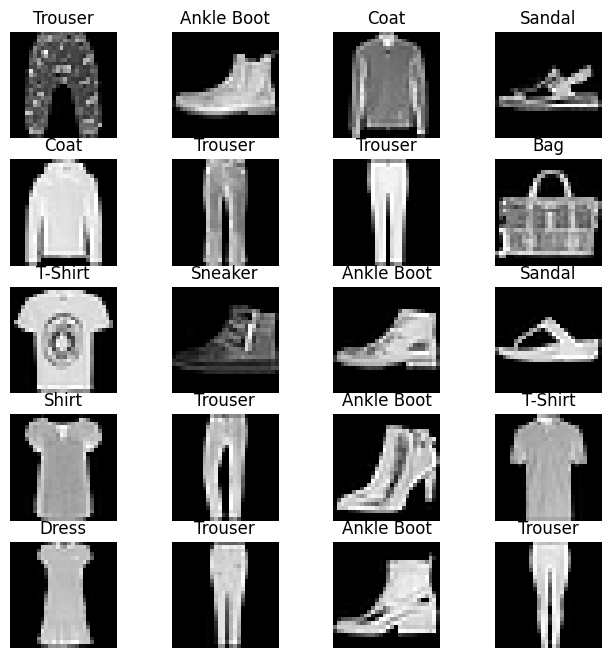

In [7]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize = (8, 8))
columns = 4;
rows = 5;

for i in range(1, columns * rows + 1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0, :, :]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

plt.show()

### 심층 신경망 모델 생성

In [12]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features = 784, out_features = 256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

### 심층 신경망에서 필요한 파라미터 정의

In [13]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### 심층 신경망을 이용한 모델 학습

In [14]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []


for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%". format(count, loss.data, accuracy))

Iteration : 500, Loss : 0.5879363417625427, Accuracy : 83.22999572753906%
Iteration : 1000, Loss : 0.43088939785957336, Accuracy : 84.70999908447266%
Iteration : 1500, Loss : 0.36766505241394043, Accuracy : 84.00999450683594%
Iteration : 2000, Loss : 0.39938950538635254, Accuracy : 85.8699951171875%
Iteration : 2500, Loss : 0.20620255172252655, Accuracy : 85.77999877929688%
Iteration : 3000, Loss : 0.2877397835254669, Accuracy : 86.27999877929688%


### 합성곱 네트워크 생성

In [19]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

### 합성곱 네트워크를 위한 파라미터 정의

In [20]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);

print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


### 모델 학습 및 성능 평가

In [21]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []


for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%". format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 500, Loss : 0.4565816819667816, Accuracy : 87.97000122070312%
Iteration : 1000, Loss : 0.2986677289009094, Accuracy : 88.79999542236328%
Iteration : 1500, Loss : 0.35848894715309143, Accuracy : 87.95999908447266%
Iteration : 2000, Loss : 0.22441203892230988, Accuracy : 89.69999694824219%
Iteration : 2500, Loss : 0.14014087617397308, Accuracy : 89.97000122070312%
Iteration : 3000, Loss : 0.19331488013267517, Accuracy : 90.41999816894531%
